In [1]:
import requests
import bs4
import os
import re
import unicodedata
import pandas as pd
import nltk
import prepare
import explore as ex

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import user, password, host
import utilities as util

# 1. Spam Data

### a. Load the spam data set. 

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [3]:
def counts_and_ratios(df, column):
    '''
    Description:
    -----------
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    
    Parameters:
    ----------
    df: Dataframe
        Dataframe being explored
    column: str
        Columns should be a categorical or binary column.
    '''
    labels = pd.concat([df[column].value_counts(),
                   df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'pct']
    
    return labels

In [4]:
counts_and_ratios(df, 'label')

,n,pct
ham,4825,0.865937
spam,747,0.134063


In [5]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [8]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [9]:
word_counts.sort_values(by='spam', ascending=False).head(10)

,all,ham,spam
call,600,241,359
free,275,59,216
txt,163,13,150
ur,384,240,144
text,214,77,137
mobile,150,15,135
4,287,168,119
claim,115,0,115
stop,153,40,113
reply,145,43,102


In [10]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


In [11]:
from wordcloud import WordCloud

In [12]:
ham_string = ' '.join(ham_words)

In [13]:
ham_string = re.sub(r'[\s]+', ' ', ham_string)

(-0.5, 399.5, 199.5, -0.5)

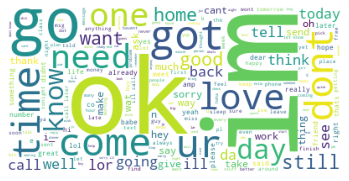

In [14]:
img = WordCloud(background_color='white').generate(ham_string)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

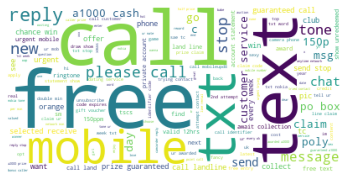

In [15]:
spam_string = ' '.join(spam_words)
spam_string = re.sub(r'[\s]+', ' ', spam_string)

img = WordCloud(background_color='white').generate(spam_string)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

In [16]:
bigrams = nltk.ngrams(spam_string.split(), 2)
trigrams = nltk.ngrams(spam_string.split(), 3)

In [17]:
top_20_spam_bigrams = (pd.Series(bigrams).value_counts().head(20))

top_20_spam_bigrams.head(20)

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(selected, receive)     19
(send, stop)            19
(chance, win)           19
(every, week)           19
(await, collection)     19
(land, line)            18
(urgent, mobile)        18
(claim, call)           17
(valid, 12hrs)          17
(account, statement)    16
(sae, tc)               16
(call, 08000930705)     16
(prize, claim)          16
(call, mobileupd8)      15
dtype: int64

In [18]:
top_20_spam_trigrams = (pd.Series(trigrams).value_counts().head(20))

top_20_spam_trigrams.head(20)

(prize, guaranteed, call)              21
(call, customer, service)              15
(reply, call, 08000930705)             14
(land, line, claim)                    14
(private, 2003, account)               13
(2003, account, statement)             13
(camcorder, reply, call)               12
(guaranteed, a1000, cash)              12
(show, 800, unredeemed)                12
(please, call, customer)               11
(anytime, network, min)                11
(urgent, trying, contact)              11
(tone, 4, ur)                          11
(every, week, txt)                     11
(bonus, caller, prize)                 11
(cash, await, collection)              10
(customer, service, representative)    10
(speak, live, operator)                10
(a2000, bonus, caller)                 10
(800, unredeemed, point)                9
dtype: int64

### c. Is there any overlap in the bigrams for the spam data and the ham data?

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

# 2. Explore the blog articles using the techniques discussed in the exploration lesson.



In [19]:
codeup = pd.read_csv('codeup_blogs.csv')
codeup.drop(columns=['Unnamed: 0'], inplace=True)
codeup.head()

,title,body
0,The Best Path to a Career in Data Science,"In our blog, “The Best Path To A Career In Sof..."
1,"Hey Dallas, Meet Your Software Development Men...","We may be new to town here in Dallas, but Code..."
2,5 Tools Every Programmer Should Use,5 Tools Every Programmer Should Use\nEvery tra...
3,How I Went From Codeup to Business Owner,"Out of college, I was a bit of a mess. That’s ..."
4,How Codeup Paid Off for Both Employee and Empl...,"After graduating from Codeup in 2016, Stan H. ..."


In [20]:
codeup['lemmed_body'] = ([prepare.clean_lem_stop(string) for string in codeup.body])

In [21]:
codeup.head()

,title,body,lemmed_body
0,The Best Path to a Career in Data Science,"In our blog, “The Best Path To A Career In Sof...",blog best path career software development loo...
1,"Hey Dallas, Meet Your Software Development Men...","We may be new to town here in Dallas, but Code...",may new town dallas codeup ha long history tra...
2,5 Tools Every Programmer Should Use,5 Tools Every Programmer Should Use\nEvery tra...,5 tool every programmer useevery trade ha tool...
3,How I Went From Codeup to Business Owner,"Out of college, I was a bit of a mess. That’s ...",college wa bit mess thats would told anyway su...
4,How Codeup Paid Off for Both Employee and Empl...,"After graduating from Codeup in 2016, Stan H. ...",graduating codeup 2016 stan h wa hired digital...


In [22]:
blog_words = ' '.join(codeup.lemmed_body)

In [23]:

extra_words = 'codeup'

blog_words = prepare.remove_stopwords(blog_words, extra_words, exclude_words=None)

In [24]:
blog_freq = pd.Series(blog_words)


In [25]:
blog_freq = pd.Series(blog_freq[0].split())

In [26]:
blog_freq.value_counts()

data          530
wa            419
job           256
career        234
science       231
             ... 
grander         1
duration        1
rocket          1
microsofts      1
breakdown       1
Length: 6322, dtype: int64

# 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring. 

In [27]:
categories = ['india',
'business',
'sports',
'world',
'politics',
'technology',
'startup',
'entertainment',
'miscellaneous',
'hatke',
'science',
'automobile']

In [28]:
def inshorts_articles(article, cat):
    return {
        'title': article.find(itemprop="headline").text,
        'body': article.find(itemprop="articleBody").text,
        'author': article.find(class_="author").text,
        'date_modified': article.find(clas="date").text,
        'time_modified': article.find(class_="time").text,
        'category': cat,
    }


def get_inshorts_articles(categories):
    
    inshort_df = pd.DataFrame(columns=['title', 'body','author','date_modified','time_modified'])
    base_url = 'https://inshorts.com/en/read/'
    
    for cat in categories:
        url = str(base_url + cat)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        response = requests.get(url, headers=headers)
        html = response.text
        soup = bs4.BeautifulSoup(html)
        container = soup.select('.card-stack')[0]
        articles = container.select('.news-card.z-depth-1')
        article = articles[0]
        
        # converts dictionary into a dataframe
        article_df = pd.DataFrame([inshorts_articles(article, cat) for article in articles])
    
        # concats the container_df to the blog_df created earlier
        inshort_df = pd.concat([inshort_df, article_df], axis=0)
    
    return inshort_df.reset_index(drop=True)

In [29]:
news = get_inshorts_articles(categories)

In [30]:
news.head(1)

,title,body,author,date_modified,time_modified,category
0,"Nigerian weightlifter in dope net, India may gain",India may move up after Nigerian weightlifter ...,Sumedha Sehra,"29 Jul 2014,Tuesday",06:47 pm,india


In [31]:
news['lem_body'] = [prepare.clean_lem_stop(string) for string in news.body]

In [32]:
news.head()

,title,body,author,date_modified,time_modified,category,lem_body
0,"Nigerian weightlifter in dope net, India may gain",India may move up after Nigerian weightlifter ...,Sumedha Sehra,"29 Jul 2014,Tuesday",06:47 pm,india,india may move nigerian weightlifter chika ama...
1,Bharti Airtel rakes in 61% profit,"Bharti Airtel, India's top telecommunications ...",Sumedha Sehra,"29 Jul 2014,Tuesday",06:53 pm,india,bharti airtel india ' top telecommunication co...
2,India beat NZ 3-2 to enter CWG hockey finals,In the CWG men's hockey semi-final against New...,Sumedha Sehra,"03 Aug 2014,Sunday",12:13 am,india,cwg men ' hockey semifinal new zealand saturda...
3,India's first Billiards Premier League,The Billiards and Snooker Association of Mahar...,Sumedha Sehra,"05 Aug 2014,Tuesday",08:00 pm,india,billiards snooker association maharashtrabsam ...
4,Zimbabwe players ask India for cricketing tips,After getting thrashed by India by 5-0 in the ...,Durga Ranjan,"04 Aug 2013,Sunday",07:04 pm,india,getting thrashed india 50 concluded odi series...


In [33]:
politcs = news[news.category == 'politics']
sports = news[news.category == 'sports']

In [34]:
pol_string = ' '.join(politcs.lem_body)
sport_string = ' '.join(sports.lem_body)

In [35]:
def create_wordcloud(string):
    # generates an img
    img = WordCloud(background_color='white').generate(ham_string)
    # WordCloud() produces an image object, which can be displayed with plt.imshow
    plt.imshow(img)
    # axis aren't very useful for a word cloud
    plt.axis('off')

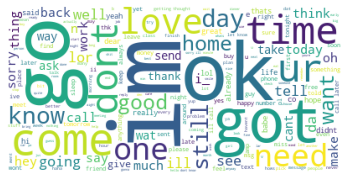

In [36]:
create_wordcloud(pol_string)

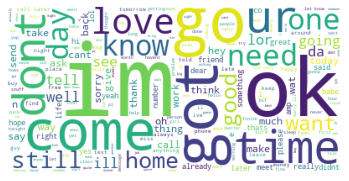

In [37]:
create_wordcloud(sport_string)

In [38]:
pol_string = prepare.remove_stopwords(pol_string, extra_words='\'', exclude_words=None)

In [39]:
pol_freq = pd.Series(pol_string.split()).value_counts()


In [40]:
sport_string = prepare.remove_stopwords(sport_string, extra_words='\'', exclude_words=None)

In [41]:
sport_freq = pd.Series(sport_string.split()).value_counts()

In [42]:
all_string = pol_string + sport_string

In [43]:
all_freq = pd.Series(all_string.split()).value_counts()

In [44]:
word_counts = (pd.concat([all_freq, pol_freq, sport_freq], axis=1, sort=True)
                .set_axis(['all', 'politics', 'sports'], axis=1, inplace=False)
                .fillna(0))
#                 .apply(lambda s: s.astype(int)
                      

word_counts.head()

,all,politics,sports
10,1.0,0.0,1.0
100,1.0,0.0,1.0
10000,1.0,1.0,0.0
11,1.0,0.0,1.0
118yearold,1.0,0.0,1.0


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

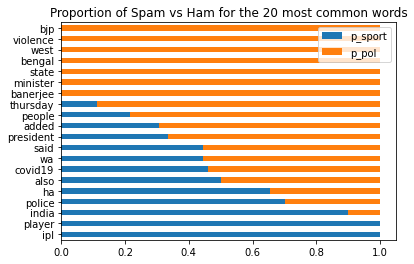

In [45]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_sport=word_counts.sports / word_counts['all'],
         p_pol=word_counts.politics / word_counts['all'])
 .sort_values(by='all')
 [['p_sport', 'p_pol']]
 .tail(20)
 .sort_values('p_pol')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [46]:
word_counts

,all,politics,sports
10,1.0,0.0,1.0
100,1.0,0.0,1.0
10000,1.0,1.0,0.0
11,1.0,0.0,1.0
118yearold,1.0,0.0,1.0
...,...,...,...
wriddhiman,1.0,0.0,1.0
wrote,5.0,2.0,3.0
year,4.0,3.0,1.0
yet,1.0,0.0,1.0


In [47]:
word_counts = ex.compare_word_counts(news, 'body', 'category', 'politics', 'sports')

In [48]:
ex.proportion_graph(word_counts, 'sports', 'politics')

KeyError: "None of [Index(['p_sports', 'p_politics'], dtype='object')] are in the [columns]"